In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams['font.sans-serif'] = 'Arial'
from scipy import stats
from tqdm import tqdm
from collections import defaultdict

In [2]:
from matplotlib.cm import get_cmap
import matplotlib as mpl

# 不同类别道路的宽度
class_width_dict = {'living_street': 0.5,
 'motorway': 1.4,
 'motorway_link': 1.4,
 'primary': 1.1,
 'primary_link': 1.1,
 'residential': 0.5,
 'secondary': 0.9,
 'secondary_link': 0.9,
 'tertiary': 0.7,
 'tertiary_link': 0.7,
 'trunk': 1.3,
 'trunk_link': 1.3,
 'unclassified': 0.5}

In [3]:
with open('data/reduction_spatial.pkl', 'rb') as f:
    spatial_reduction_dict = pickle.load(f)
reduce_dict01 = spatial_reduction_dict[0.1]
reduce_dict03 = spatial_reduction_dict[0.3]

In [4]:
with open('data/jn_road.pkl', 'rb') as f:
    G, eid2ci, id2class = pickle.load(f)

def matplot_carbon_itensity(G, eid2ci, max_ci, min_ci=0.1, step = 0.01, log=True, set_lim = False, lims = None):

    cmap = get_cmap('Reds').copy()
    gray = "#D3D3D3"
    cmap.set_under(gray)
    cmap.set_over(cmap(1.0))

    if log:
        min_ci = np.log10(min_ci)
        max_ci = np.log10(max_ci)
        eid2ci = {k: np.log10(v) for k, v in eid2ci.items()}

    def getc(ci):
        step = 0.01
        if ci <= min_ci:
            return cmap(0.0)
        elif ci >= max_ci:
            return cmap(1.0)
        else:
            r = (ci - min_ci) / (max_ci - min_ci)
            return cmap(int(r / step) * step) 

    c2eids = defaultdict(list)

    for eid, ci in eid2ci.items():
        c2eids[getc(ci)].append(eid)
    for *_, e in G.edges(data=True):
        if e["id"] not in eid2ci:
            c2eids[gray].append(e["id"])

    xmin, ymin, xmax, ymax = G.graph["bound"]
    lx, ly = xmax - xmin, ymax - ymin
    p = 12 / max(lx, ly)
    fig, ax = plt.subplots(figsize=(lx * p, ly * p))
    eid2xys = {e["id"]: e["points_xy"] for *_, e in G.edges(data=True)}
    for c, eids in tqdm(c2eids.items()):
        if c == gray:
            ps = [eid2xys[eid] for eid in eids]
            ax.plot(
            *[vs for xys in ps for vs in zip(*xys)], 
            c=c,
            linewidth = 0.3,
            zorder=0,
            alpha=0.8)
        else:
            for lw in list(set(class_width_dict.values())):
                ps = [eid2xys[eid] for eid in eids if class_width_dict[id2class[eid]] == lw]
                ax.plot(
                *[vs for xys in ps for vs in zip(*xys)], 
                c=c,
                linewidth = lw,
                zorder = 1,
                alpha=0.8)
                
    if log:
        norm = mpl.colors.LogNorm(vmin=10**min_ci, vmax=10**max_ci)
    else:
        norm = mpl.colors.Normalize(vmin=min_ci, vmax=max_ci)

    scalarmap = mpl.cm.ScalarMappable(
        norm=norm,
        cmap=cmap)
    cbar = fig.colorbar(
        scalarmap, 
        ax=ax, 
        extend="both", 
        orientation='horizontal' if lx < ly else "vertical",
        pad=-0.05 if lx < ly else -0.12, 
        aspect=35,
        fraction=0.01,
        location="bottom" if lx < ly else "right",
    )

    cbar.set_label(r"Reduced CO$_2$ Emission (%)", fontsize=14)

    plt.axis("equal")
    plt.axis("off")
    if set_lim:
        x0, x1, y0, y1 = lims
        plt.xlim(xmin + lx * x0, xmin + lx * x1)
        plt.ylim(ymin + ly * y0, ymin + ly * y1)
    plt.tight_layout()
    plt.show()

# Figure 4a

C:\Users\ZYK\AppData\Local\Temp\ipykernel_30164\3121853350.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds').copy()
100%|██████████| 96/96 [00:07<00:00, 13.25it/s]


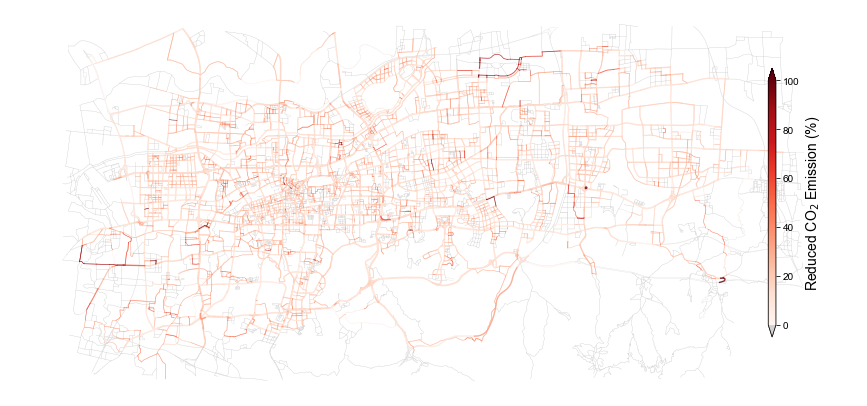

In [5]:
matplot_carbon_itensity(G, reduce_dict01, max_ci = 100, min_ci = 0, step = 0.01, log=False)

# Figure 4b

C:\Users\ZYK\AppData\Local\Temp\ipykernel_30164\3121853350.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds').copy()
100%|██████████| 101/101 [00:08<00:00, 11.94it/s]


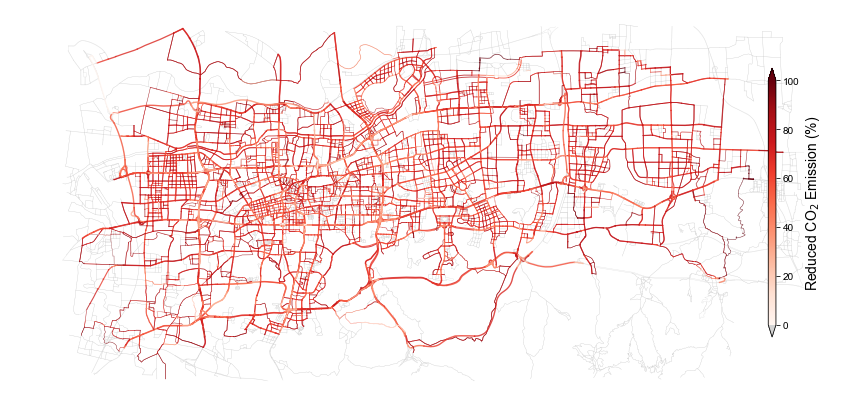

In [6]:
matplot_carbon_itensity(G, reduce_dict03, max_ci = 100, min_ci = 0, step = 0.01, log=False)

# Figure 4c

In [7]:
def calculate_confidence_interval(data):
    if all(x == 0 for x in data):
        return 0, 0
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    df = n - 1
    t_critical = stats.t.ppf(1 - 0.025, df)
    se = std / np.sqrt(n)
    lower_bound = mean - t_critical * se
    upper_bound = mean + t_critical * se
    return lower_bound, upper_bound

In [8]:
# base emission
cbase = float(open(f"data/simulation_results/20240909-210535-jn230226.txt").readline())
pc, pt = 0.5684691886282743, 0.08803836851132395

In [9]:
# read total emission of simulation scenarios
res_dir = 'data/simulation_results/'
sim_results = os.listdir(res_dir)
res = {}

for fname in sim_results:
    if '.txt' not in fname:
        continue
    if 'jn230226' not in fname:
        continue
    temp = fname.split('_')
    if len(temp) == 1:
        continue
    ntype = temp[1][0]
    frac = float(temp[1].split('.')[0][1] + '.' + temp[1].split('.')[0][2:])

    if ntype not in res.keys():
        res[ntype] = {}
    if frac not in res[ntype].keys():
        res[ntype][frac] = []
    res[ntype][frac].append(float(open(res_dir+fname).readline()))

res['s'][0.0] = [0]

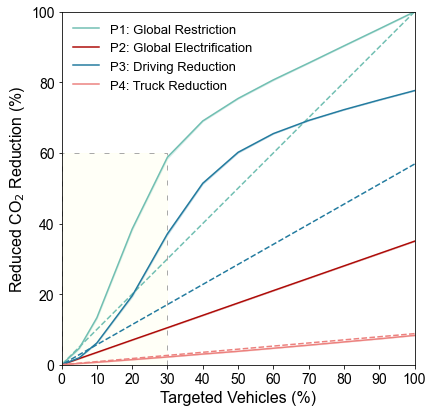

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = ['#71BFB2', '#237B9F', '#EC817E', '#AD0B08']
lw = 1.5
plt.xlim(0, 1)
plt.ylim(0, 1)

for k in ['s', 'e', 'c',  't']:
    xs = sorted(res[k].keys())
    ys = [1 - np.mean(res[k][x]) / cbase for x in xs]
    ymins = [1- calculate_confidence_interval(res[k][x])[1] / cbase for x in xs]
    ymaxs = [1- calculate_confidence_interval(res[k][x])[0] / cbase for x in xs]
    
    if k != 'e':
        xs = [1 - x for x in xs]
        xs = xs + [0]
        ys = ys + [0]
        ymins = ymins + [0]
        ymaxs = ymaxs + [0]

    if k == 'e':
        xs = [0] + xs
        ys = [0] + ys
        ymins = [0] + ymins
        ymaxs = [0] + ymaxs

    if k == 's':
        plt.plot(xs, ys, color=colors[0], lw = lw, label="P1: Global Restriction")
        plt.plot(xs, xs, color=colors[0], lw = lw, linestyle="--")
        plt.fill_between(xs, ymins, ymaxs, color = colors[0], alpha = 0.2)

    if k == 'e':
        plt.plot(xs, ys, color=colors[3], lw = lw, label="P2: Global Electrification")
        plt.fill_between(xs, ymins, ymaxs, color = colors[3], alpha = 0.2)

    if k == 'c':
        plt.plot(xs, ys, color=colors[1], lw = lw,label="P3: Driving Reduction")
        plt.plot(xs, np.array(xs) * pc, color=colors[1], lw = lw, linestyle="--")
        plt.fill_between(xs, ymins, ymaxs, color = colors[1], alpha = 0.2)
        
    if k == 't':
        plt.plot(xs, ys, color=colors[2], lw = lw,label="P4: Truck Reduction")
        plt.plot(xs, np.array(xs) * pt, color=colors[2], lw = lw, linestyle="--")
        plt.fill_between(xs, ymins, ymaxs, color = colors[2], alpha = 0.2)

plt.legend(frameon = False, fontsize = 13)
plt.xlabel("Targeted Vehicles (%)", size = 16)
plt.ylabel(r"Reduced CO$_2$ Reduction (%)", size = 16)

plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size = 14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 20, 40, 60, 80, 100], size = 14)
ax.set_aspect('equal')

x = [0, 0.3, 0.3, 0, 0]
y = [0, 0, 0.6, 0.6, 0]
ax.fill_between(x, y, color='lightyellow', alpha = 0.25)
ax.plot(x, y, linestyle=(0, (5, 10)), color='darkgray', lw = 1)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Figure 4d

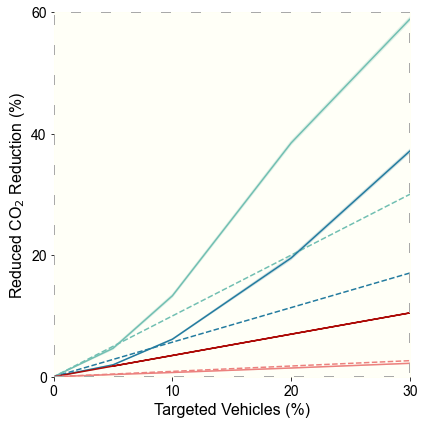

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = ['#71BFB2', '#237B9F', '#EC817E', '#AD0B08']
lw = 1.5
plt.xlim(0, 1)
plt.ylim(0, 1)

for k in ['s', 'c', 'e', 't']:
    xs = sorted(res[k].keys())
    ys = [1 - np.mean(res[k][x]) / cbase for x in xs]
    ymins = [1- calculate_confidence_interval(res[k][x])[1] / cbase for x in xs]
    ymaxs = [1- calculate_confidence_interval(res[k][x])[0] / cbase for x in xs]
    
    if k != 'e':
        xs = [1 - x for x in xs]
    xs = xs + [0]
    ys = ys + [0]
    ymins = ymins + [0]
    ymaxs = ymaxs + [0]

    if k == 's':
        plt.plot(xs, ys, color=colors[0], lw = lw, label="Global Restriction")
        plt.plot(xs, xs, color=colors[0], lw = lw, linestyle="--")
        plt.fill_between(xs, ymins, ymaxs, color = colors[0], alpha = 0.2)

    if k == 'e':
        plt.plot(xs, ys, color=colors[3], lw = lw, label="Global Electrification")
        plt.fill_between(xs, ymins, ymaxs, color = colors[3], alpha = 0.2)

    if k == 'c':
        plt.plot(xs, ys, color=colors[1], lw = lw,label="Driving Reduction")
        plt.plot(xs, np.array(xs) * pc, color=colors[1], lw = lw, linestyle="--")
        plt.fill_between(xs, ymins, ymaxs, color = colors[1], alpha = 0.2)
        
    if k == 't':
        plt.plot(xs, ys, color=colors[2], lw = lw,label="Truck Reduction")
        plt.plot(xs, np.array(xs) * pt, color=colors[2], lw = lw, linestyle="--")
        plt.fill_between(xs, ymins, ymaxs, color = colors[2], alpha = 0.2)

# plt.legend(frameon = False, fontsize = 13)
plt.xlabel("Targeted Vehicles (%)", size = 16)
plt.ylabel(r"Reduced CO$_2$ Reduction (%)", size = 16)

plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size = 14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 20, 40, 60, 80, 100], size = 14)
# ax.set_aspect('equal')

x = [0, 0.3, 0.3, 0, 0]
y = [0, 0, 0.6, 0.6, 0]
ax.fill_between(x, y, color='lightyellow', alpha = 0.25)
ax.plot(x, y, linestyle=(0, (5, 10)), color='darkgray', lw = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.xlim(0, 0.3)
plt.ylim(0, 0.6)
plt.tight_layout()
plt.show()

# Figure 4e

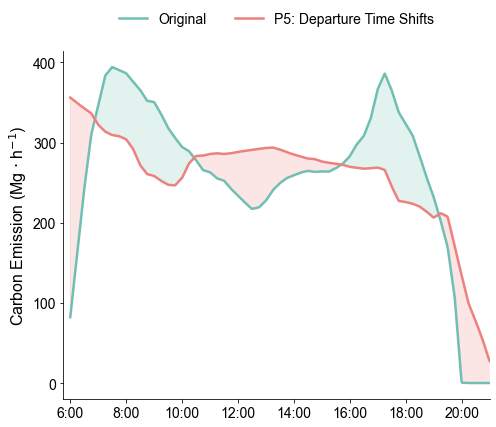

In [12]:
with open('data/depeak.pkl', 'rb') as f:
    depeak_results = pickle.load(f)
orig_emission = depeak_results['orig']
depeak_vector = depeak_results['depeak']

fine_days = np.linspace(0, 61, 500)
days = range(61)
interp_emis0 = np.interp(fine_days, days, orig_emission) / 1e6 * 4
interp_emis1 = np.interp(fine_days, days, depeak_vector) / 1e6 * 4

fig, ax = plt.subplots(figsize=(7, 6))
plt.plot(fine_days, interp_emis0, label='Original', lw=2.5, color='#71BFB2')
plt.plot(fine_days, interp_emis1, label='P5: Departure Time Shifts', lw=2.5, color='#EC817E')
plt.fill_between(fine_days, interp_emis0, interp_emis1, where=interp_emis0>interp_emis1, alpha=0.2, color='#71BFB2')
plt.fill_between(fine_days, interp_emis0, interp_emis1, where=interp_emis0<interp_emis1, alpha=0.2, color='#EC817E')

ax.legend(loc='upper center', ncol=2, frameon=False, fontsize=14, bbox_to_anchor=(0.5, 1.15))
ax.set_xlim(-1, 60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel(r'Carbon Emission (Mg $\cdot$ h$^{-1}$)', size=16)
plt.yticks(range(0, 401, 100), size=14)
plt.xticks(range(0, 62, 8), ['%d:00' % x for x in range(6, 22, 2)], size=14)
plt.tight_layout()
plt.show()